In [2]:
import numpy as np
import numpy.random as rndm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fmin
import seaborn as sns
from matplotlib.lines import Line2D


In [21]:
# Colors
blue = "#003E74"
red = "#A51900"
green = "#66A40A"

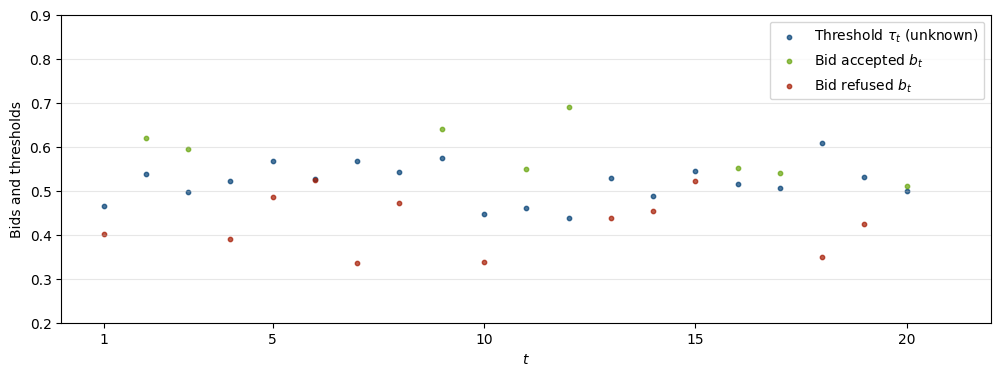

In [4]:
rndm.seed(13)
N = 20
sigma = 0.05
plt.rcParams["figure.figsize"] = (12,4)
thresholds = rndm.normal(0.5, sigma, N)
bids = rndm.normal(0.5, 2 * sigma, N)
bids_above = [bids[i] if bids[i] > thresholds[i] else None for i in range(len(thresholds))]
bids_below = [bids[i] if bids[i] < thresholds[i] else None for i in range(len(thresholds))]

plt.scatter(range(0,N), thresholds, s = 10, c = blue, alpha= 0.7, label = r"Threshold $\tau_t$ (unknown)")
plt.scatter(range(0,N), bids_above, s = 10, c = green, alpha= 0.7, label = r"Bid accepted $b_t$")
plt.scatter(range(0,N), bids_below, s = 10, c = red, alpha= 0.7, label = r"Bid refused $b_t$")
plt.ylim((0.2,0.9))
plt.xlim((-1,21))
plt.xlabel(r"$t$")
plt.ylabel("Bids and thresholds")
plt.xticks([0,4,9,14, 19], [1,5,10,15, 20])
plt.legend()
plt.grid(axis = "y", alpha = 0.3)
plt.savefig("../figures/bid_threshold.pdf")
plt.show()


In [5]:
# Compute reward for a given bid and threshold
def reward(bid, tau, bsup = 1):
    return (bsup - bid) * (tau <= bid)
# Compute reward expection given the range of an arm and mean, standard deviation of thresholds (normally distributed)
def get_mu(a0, a1, tau, sigma, bsup = 1):
    a0_tilde = (a0 - tau) / sigma
    a1_tilde = (a1 - tau) / sigma
    return sigma/(2 * (a1 - a0)) * (norm.cdf(a1_tilde) * (sigma - a1_tilde * (tau - 2 * bsup + a1)) - norm.cdf(a0_tilde) * (sigma - a0_tilde * (tau - 2 * bsup + a0)) + norm.pdf(a1_tilde) * (2 * (bsup - tau) - sigma * a1_tilde) - norm.pdf(a0_tilde) * (2 * (bsup - tau) - sigma * a0_tilde))
# Find expectation max given a partition and threshold ditribution parameters
def get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = False):
    x0 = 0.5
    increment = bsup / (len(partition) - 1)
    a0_star = round(fmin(lambda a0: - get_mu(a0, a0 + increment, tau, sigma),
           x0,
           xtol = increment / 10,
           disp = 0)[0] * 1 / increment) * increment
    if get_mu(a0_star, a0_star + increment, tau, sigma, bsup) < get_mu(a0_star + increment, a0_star + 2 * increment, tau, sigma, bsup):
        a0_star = a0_star + increment
    if unif_range:
        return get_mu(a0_star, a0_star + increment, tau, sigma, bsup), (a0_star, a0_star + increment)
    else:
        return get_mu(a0_star, a0_star + increment, tau, sigma, bsup)
# Find second moment
def get_second_moment(a0, a1, tau, sigma, bsup = 1):
    a0_tilde = (a0 - tau) / sigma
    a1_tilde = (a1 - tau) / sigma
    sigma2 = sigma ** 2
    sigma3 = sigma ** 3
    bsup_tau = bsup - tau
    bsup_tau2 = bsup_tau ** 2
    bsup_tau3 = bsup_tau ** 3
    return 1 / (3 * (a1 - a0)) * (norm.cdf(a1_tilde) * (bsup_tau3 + 3 * sigma2 * bsup_tau - (bsup - a1)**3) - norm.cdf(a0_tilde) * (bsup_tau3 + 3 * sigma2 * bsup_tau - (bsup - a0)**3) + norm.pdf(a1_tilde) * (sigma3 * (a1_tilde ** 2 + 2) + 3 * sigma * bsup_tau2 - 3 * sigma2 * bsup_tau * a1_tilde) - norm.pdf(a0_tilde) * (sigma3 * (a0_tilde ** 2 + 2) + 3 * sigma * bsup_tau2 - 3 * sigma2 * bsup_tau * a0_tilde))
# Find variance
def get_variance(a0, a1, tau, sigma, bsup = 1):
    return get_second_moment(a0, a1, tau, sigma, bsup) - get_mu(a0, a1, tau, sigma, bsup)**2

In [13]:
# Sequential halving (return list of ranges for the selected arm for each round)
def sequential_halving_algorithm(tau, sigma, partition, delta, seed = None, itermax = 5e4, bernstein = True, oracle = False):
    """
    Sequential Halving algorithm
    :param tau: mean of the threshold distribution
    :type tau: float positive
    :param sigma: standard deviation of the threshold distribution
    :type sigma: float positive
    :param partition: bounds of the bids
    :type partition: numpy.ndarray
    :param delta: confidence parameter
    :type delta: float between 0 and 1
    :param seed: random seed
    :type seed: int
    :param itermax: maximum number of rounds
    :type itermax: int
    :param bernstein: indicator Bernstein's bounds (True) or Hoeffding's bounds (False)
    :type bernstein: boolean
    :param oracle: indicator compute the theoritical variance (True) 
    or the empirical variance (False) when Bernstein = True
    :type oracle: boolean
    :returns: list of the selected arms, array of empirical average rewards for each arm, 
    array of counts for each arm, tupple of three terminal arms (left, middle, right), 
    best arm at the end of the algorithm, number of rounds played
    """
    rndm.seed(seed)
    J = len(partition) - 1 # number of arms
    avg_arm_reward = np.zeros(J) # array of empirical average rewards
    arm_count = np.zeros(J) # array of counts
    if bernstein:
        dict_rewards = {} # dictionary to save all the rewards of each arm for empirical standard deviation computation
    selected_arm = [] # selected arms up to rount t

    bound_reward = np.array([1 - j/J for j in range(J)]) # upper bounds of the reward for each arm
    # Compute constants in bound's formulas
    constant_bernstein_1 = 2 * np.log(1/delta)
    constant_bernstein_2 = 3 * np.log(1/delta)
    constant_hoeffding = np.log(1/delta)/2
    # Left, middle and right arm initialisation
    left_index = 0
    mid_index = int((J)/2)
    right_index = J - 1
    consecutive = 0 # Indicator that the three arms are consecutive
    t = 0
    while 1:
        # Play three arms
        for ind in [left_index, mid_index, right_index]:
            threshold = sigma * rndm.randn() + tau # new threshold
            bid = partition[ind] + (partition[ind + 1] - partition[ind]) * rndm.rand() # new bid
            rew = reward(bid, threshold) # get the reward
            arm_count[ind] += 1 # update the count
            avg_arm_reward[ind] = ((arm_count[ind] - 1) * avg_arm_reward[ind] + rew) / arm_count[ind] # update the empirical average reward
            if bernstein: # update the rewards if bernstein
                if not (f"arm_{ind}" in dict_rewards):
                    dict_rewards[f"arm_{ind}"] = [] 
                dict_rewards[f"arm_{ind}"].append(rew)
            selected_arm.append(ind) # selected arm at round t
            t += 1 # new round
             # stop the while loop if round itermax
            if t == itermax:
                break
        if t == itermax:
            break
        # Get the configuration of the three arms
        ascending = (avg_arm_reward[left_index] <= avg_arm_reward[mid_index]) and (avg_arm_reward[mid_index] <= avg_arm_reward[right_index])
        descending = (avg_arm_reward[left_index] > avg_arm_reward[mid_index]) and (avg_arm_reward[mid_index] > avg_arm_reward[right_index])
        peak = (avg_arm_reward[left_index] < avg_arm_reward[mid_index]) and (avg_arm_reward[mid_index] > avg_arm_reward[right_index])
        # if the arms are consecutive, UCBs and LCBs need to be computed
        if consecutive:    
            if peak: # peak configuration
                if bernstein: 
                    if not oracle:
                        # empirical standard deviations of the three arms
                        left_std = np.array(dict_rewards[f"arm_{left_index}"]).std() 
                        mid_std = np.array(dict_rewards[f"arm_{mid_index}"]).std()
                        right_std = np.array(dict_rewards[f"arm_{right_index}"]).std()
                    else:
                        # theoretical standard deviations of the three arms
                        left_std = np.sqrt(get_variance(partition[left_index], partition[left_index + 1], tau, sigma))
                        mid_std = np.sqrt(get_variance(partition[mid_index], partition[mid_index + 1], tau, sigma))
                        right_std = np.sqrt(get_variance(partition[right_index], partition[right_index + 1], tau, sigma))
                    # Compute the UCBs of the left and right arms et the LCB of the middle arm (Bernstein)
                    left_confidence_bound = avg_arm_reward[left_index] + left_std * np.sqrt(constant_bernstein_1 / arm_count[left_index]) + bound_reward[left_index] * constant_bernstein_2 / arm_count[left_index]
                    mid_confidence_bound = avg_arm_reward[mid_index] - mid_std * np.sqrt(constant_bernstein_1 / arm_count[mid_index]) - bound_reward[mid_index] * constant_bernstein_2 / arm_count[mid_index]
                    right_confidence_bound = avg_arm_reward[right_index] + right_std * np.sqrt(constant_bernstein_1 / arm_count[right_index]) + bound_reward[right_index] * constant_bernstein_2 / arm_count[right_index]
                else:
                    # compute the UCBs of the left and right arms et the LCB of the middle arm (Hoeffding)
                    left_confidence_bound = avg_arm_reward[left_index] + bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[left_index])
                    mid_confidence_bound = avg_arm_reward[mid_index] - bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[mid_index])
                    right_confidence_bound = avg_arm_reward[right_index] + bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[right_index])
                # check if the middle arm is the optimal arm given the bounds
                if (left_confidence_bound < mid_confidence_bound) and (right_confidence_bound < mid_confidence_bound):
                    return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), mid_index, t
            elif ascending and right_index == J-1: # ascending configuration at the far right
                if bernstein:
                    if not oracle:
                        # compute the empirical standard deviations
                        mid_std = np.array(dict_rewards[f"arm_{mid_index}"]).std()
                        right_std = np.array(dict_rewards[f"arm_{right_index}"]).std()
                    else:
                        # compute the theoritical standard deviations
                        mid_std = np.sqrt(get_variance(partition[mid_index], partition[mid_index + 1], tau, sigma))
                        right_std = np.sqrt(get_variance(partition[right_index], partition[right_index + 1], tau, sigma))
                    # Compute the UCB of the middle arm et the LCB of the right arm (Bernstein)
                    mid_confidence_bound = avg_arm_reward[mid_index] + mid_std * np.sqrt(constant_bernstein_1 / arm_count[mid_index]) + bound_reward[mid_index] * constant_bernstein_2 / arm_count[mid_index]
                    right_confidence_bound = avg_arm_reward[right_index] - right_std * np.sqrt(constant_bernstein_1 / arm_count[right_index]) - bound_reward[right_index] * constant_bernstein_2 / arm_count[right_index]
                else:
                    # Compute the UCB of the middle arm et the LCB of the right arm (Hoeffding)
                    mid_confidence_bound = avg_arm_reward[mid_index] + bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[mid_index])
                    right_confidence_bound = avg_arm_reward[right_index] - bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[right_index])
                # check if the right arm is the optimal arm given the bounds
                if (mid_confidence_bound < right_confidence_bound) and (right_confidence_bound < mid_confidence_bound):
                    return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), right_index, t
            elif descending and left_index == 0:  # descending configuration at the far left
                if bernstein:
                    if not oracle:
                        # compute the empirical standard deviations
                        left_std = np.array(dict_rewards[f"arm_{left_index}"]).std()
                        mid_std = np.array(dict_rewards[f"arm_{mid_index}"]).std()
                    else:
                        # compute the theoritical standard deviations
                        left_std = np.sqrt(get_variance(partition[left_index], partition[left_index + 1], tau, sigma))
                        mid_std = np.sqrt(get_variance(partition[mid_index], partition[mid_index + 1], tau, sigma))
                    # compute the UCB of the middle arm et the LCB of the left arm (Bernstein)
                    left_confidence_bound = avg_arm_reward[left_index] - left_std * np.sqrt(constant_bernstein_1 / arm_count[left_index]) - bound_reward[left_index] * constant_bernstein_2 / arm_count[left_index]
                    mid_confidence_bound = avg_arm_reward[mid_index] + mid_std * np.sqrt(constant_bernstein_1 / arm_count[mid_index]) + bound_reward[mid_index] * constant_bernstein_2 / arm_count[mid_index]
                else:
                    # compute the UCB of the middle arm et the LCB of the left arm (Hoeffding)
                    left_confidence_bound = avg_arm_reward[left_index] - bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[left_index])
                    mid_confidence_bound = avg_arm_reward[mid_index] + bound_reward[left_index] * np.sqrt(constant_hoeffding / arm_count[mid_index])
                # check if the left arm is the optimal arm given the bounds
                if (mid_confidence_bound < left_confidence_bound) and (right_confidence_bound < mid_confidence_bound):
                    return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), left_index, t
            peak = (avg_arm_reward[left_index] <= avg_arm_reward[mid_index]) and (avg_arm_reward[mid_index] >= avg_arm_reward[right_index])
        # new left, middle and right arms given the configuration
        if ascending:
            # right shift
            right_new = min(J - 1, 2 * right_index - mid_index)
            left_index = min(right_new - 2, mid_index)
            mid_index = min(right_new - 1, right_index)
            right_index = right_new
        elif descending:
            # left shift
            left_new = max(0, 2 * left_index - mid_index)
            right_index = max(left_new + 2, mid_index)
            mid_index = max(left_new + 1, left_index)
            left_index = left_new
        elif peak:
            # halving
            left_index = min(int((left_index + mid_index) / 2), mid_index - 1)
            right_index = max(int((right_index + mid_index) / 2), mid_index + 1)
            # check if the three arm are consecutive
            if (right_index - left_index == 2):
                consecutive = 1
    print("Max_iter")
    # Return all the results and the best arm given the configuration
    if peak:
        return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), mid_index, t
    if ascending:
        return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), right_index, t
    if descending:
        return selected_arm, avg_arm_reward, arm_count, (left_index, mid_index, right_index), left_index, t

In [14]:
tau = 0.5
sigma = 0.02
J = 50 # K arms (at least 3)
partition = np.linspace(0, 1, J+1)
results = sequential_halving_algorithm(tau, sigma, partition, itermax= 5000, seed = None, delta = 0.7, bernstein = True, oracle = False)

In [15]:
print(np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0])
print(results[-2])
print(results[-1])
print(results[-3])

27
27
348
(26, 27, 28)


In [8]:
print(get_mu(partition[29], partition[30], tau, sigma))
print(get_mu(partition[28], partition[29], tau, sigma))
print(get_mu(partition[30], partition[31], tau, sigma))

0.40999705108476847
0.4298368565577642
0.389999978867702


In [9]:
# eps-Greedy algorithm
def epsilon_t(t, J):
    return t**(-1/3)*(J * np.log(t))**(1/3)

def eps_greedy(tau, sigma, partition, seed = 123, itermax = 5e4):
    rndm.seed(seed)
    J = len(partition) - 1
    avg_arm_reward = np.zeros(J)
    arm_count = np.zeros(J)
    selected_arm = []
    t = J
    # Initialisation
    for j in range(J):
        threshold = sigma * rndm.randn() + tau
        bid = partition[j] + (partition[j + 1] - partition[j]) * rndm.rand()
        arm_count[j] += 1
        avg_arm_reward[j] = ((arm_count[j] - 1) * avg_arm_reward[j] + reward(bid, threshold)) / arm_count[j]
        selected_arm.append(j)
        # Exploration/Exploitation:
    while t < itermax:
        threshold = sigma * rndm.randn() + tau
        if rndm.rand() < epsilon_t(t, J): # Exploration
            arm_index = rndm.randint(0, J)
        else:
            arm_index = np.argmax(avg_arm_reward)
        bid = partition[arm_index] + (partition[arm_index + 1] - partition[arm_index]) * rndm.rand()
        arm_count[arm_index] += 1
        avg_arm_reward[arm_index] = ((arm_count[arm_index] - 1) * avg_arm_reward[arm_index] + reward(bid, tau)) / arm_count[arm_index]
        selected_arm.append(arm_index)
        t += 1
    return selected_arm, avg_arm_reward, arm_count, np.argmax(avg_arm_reward)

In [10]:
results_greedy = eps_greedy(tau, sigma, partition, seed = 123, itermax= 5000)

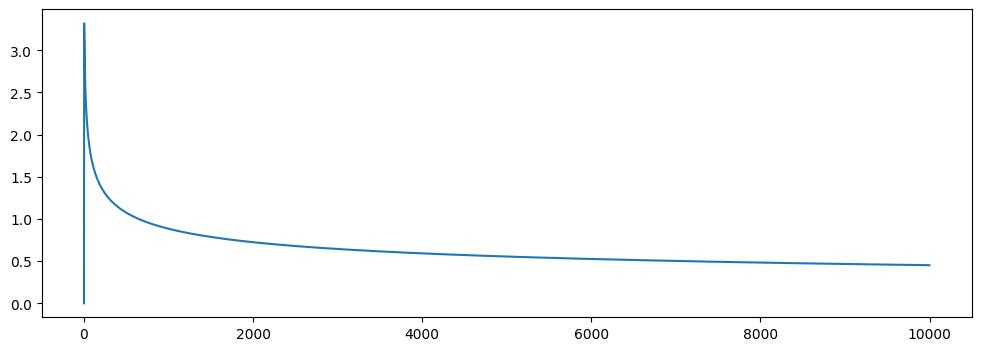

In [11]:
plt.plot(np.arange(1, 10000), [epsilon_t(t, 100) for t in np.arange(1, 10000)])
plt.show()

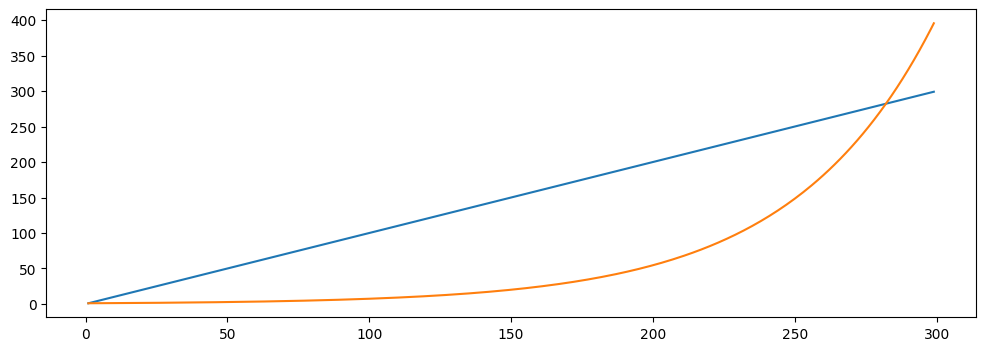

In [12]:
plt.plot(np.arange(1, 300), np.arange(1, 300))
plt.plot(np.arange(1, 300), np.exp(np.arange(1, 300)/J))
plt.show()

In [13]:
def UCB_algorithm(tau, sigma, partition, delta, seed = None, itermax = 5e4, bernstein = True, oracle = False):
    if seed != None:
        rndm.seed(seed)
    J = len(partition) - 1
    avg_arm_reward = np.zeros(J)
    arm_count = np.zeros(J)
    dict_rewards = {}
    arm_ucb = np.zeros(J)
    selected_arm = []
    t = J
    bound_reward = np.array([1 - j/J for j in range(J)])
    constant_bernstein_1 = 2 * np.log(3/delta)
    constant_bernstein_2 = 3 * np.log(3/delta)
    constant_hoeffding = np.log(2/delta)/2
    # Initialisation
    for j in range(J):
        threshold = sigma * rndm.randn() + tau
        bid = partition[j] + (partition[j + 1] - partition[j]) * rndm.rand()
        arm_count[j] += 1
        rew = reward(bid, threshold)
        avg_arm_reward[j] = ((arm_count[j] - 1) * avg_arm_reward[j] + rew) / arm_count[j]
        dict_rewards[f"arm_{j}"] = [rew]
        selected_arm.append(j)
        if bernstein:
            arm_ucb[j] = avg_arm_reward[j] + bound_reward[j] * constant_bernstein_2
        else:
            arm_ucb[j] = avg_arm_reward[j] + bound_reward[j] * np.sqrt(constant_hoeffding)
    while t < itermax:
        arm_index = np.argmax(arm_ucb)
        threshold = sigma * rndm.randn() + tau
        bid = partition[arm_index] + (partition[arm_index + 1] - partition[arm_index]) * rndm.rand()
        arm_count[arm_index] += 1
        rew = reward(bid, threshold)
        avg_arm_reward[arm_index] = ((arm_count[arm_index] - 1) * avg_arm_reward[arm_index] + rew) / arm_count[arm_index]
        dict_rewards[f"arm_{arm_index}"] = [rew]
        selected_arm.append(arm_index)
        if bernstein:
            if not oracle:
                arm_std = np.array(dict_rewards[f"arm_{arm_index}"]).std()
            else:
                arm_std = get_variance(partition[arm_index], partition[arm_index + 1], tau, sigma)
            arm_std = np.array(dict_rewards[f"arm_{arm_index}"]).std()
            arm_ucb[arm_index] = avg_arm_reward[arm_index] + arm_std * np.sqrt(constant_bernstein_1 / arm_count[arm_index]) + bound_reward[arm_index] * constant_bernstein_2 / arm_count[arm_index]
        else:
            arm_ucb[arm_index] = avg_arm_reward[arm_index] + bound_reward[arm_index] * np.sqrt(constant_hoeffding / arm_count[arm_index])
        t+=1
    return selected_arm, avg_arm_reward, arm_count, arm_ucb, np.argmax(arm_ucb), np.argmax(avg_arm_reward)


In [14]:
res_ucb = UCB_algorithm(tau, sigma, partition, 2, itermax = 5e4, bernstein = True, oracle = False)
print(res_ucb[-2])
print(res_ucb[-1])
print(np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0])

27
27
27


J = 10
J = 50
Max_iter
J = 100
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter


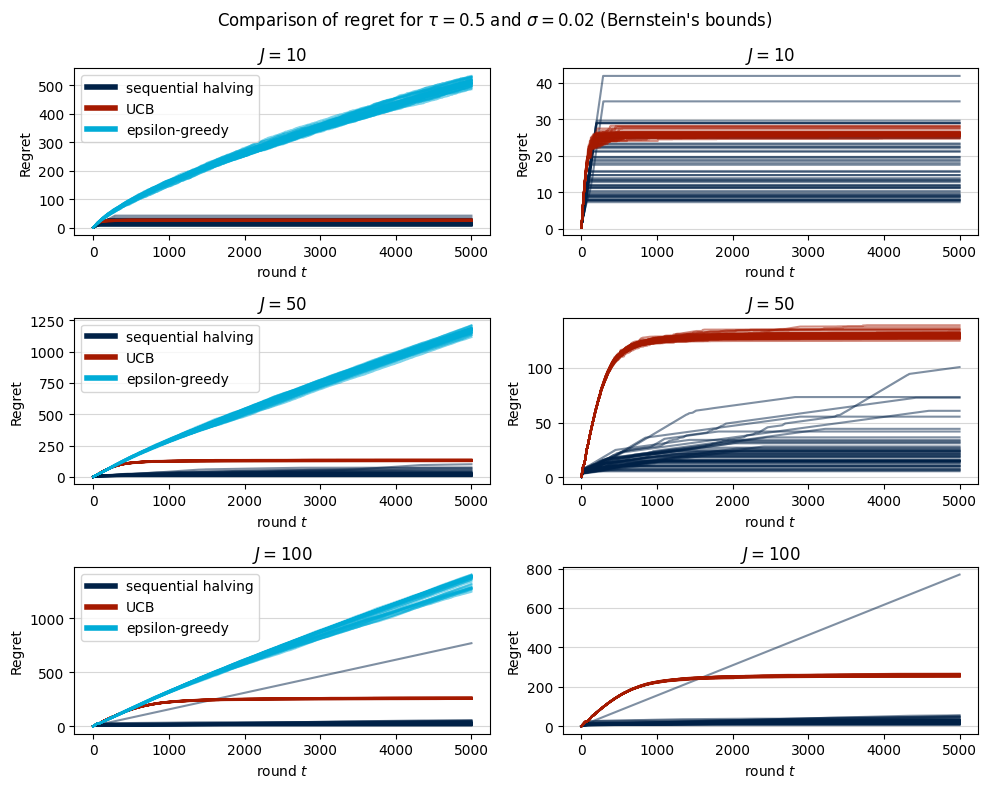

In [71]:
# Regret plot
rndm.seed(123)
colors = ["#A51900", "#002147","#00ACD7"][::-1]
nb_simu = 50
fig, ax = plt.subplots(3, 2, figsize = (10,8))
tau = 0.5
sigma = 0.02
delta = 0.6
print("J = 10")
J = 10
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)

for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[0,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = True, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[0,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[0,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])
print("J = 50")
J = 50
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)
for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[1,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = True, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[1,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[1,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])

print("J = 100")
J = 100
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)

for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[2,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = True, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[2,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[2,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])
for a in ax.flatten():
    a.set_xlabel("round $t$")
    a.set_ylabel("Regret")
    a.grid(axis="y", alpha = 0.5)
for i in range(2):
    ax[0,i].set_title("$J = 10$")
    ax[1,i].set_title("$J = 50$")
    ax[2,i].set_title("$J = 100$")
fig.suptitle(r"Comparison of regret for $\tau =$" + str(tau) + r" and $\sigma =$" + str(sigma) + " (Bernstein's bounds)")
plt.tight_layout()
plt.savefig("../figures/regret.pdf")
plt.show()

J = 10
J = 50
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
J = 100
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter
Max_iter


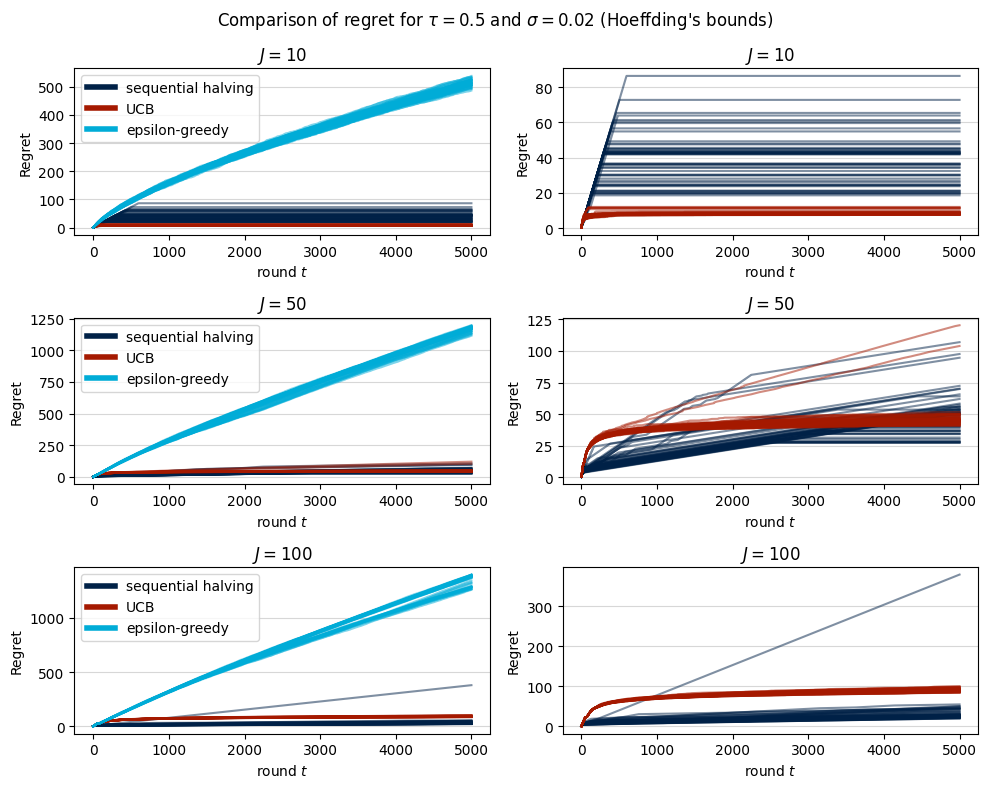

In [70]:
# Regret plot
rndm.seed(123)
colors = ["#A51900", "#002147","#00ACD7"][::-1]
nb_simu = 50
fig, ax = plt.subplots(3,2, figsize = (10,8))
tau = 0.5
sigma = 0.02
delta = 0.6
print("J = 10")
J = 10
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)

for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, bernstein = False, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[0,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = False, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[0,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[0,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[0,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])

print("J = 50")
J = 50
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)
for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, bernstein = False, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[1,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = False, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[1,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[1,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[1,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])

print("J = 100")
J = 100
partition = np.linspace(0,1, J+1)
array_mu = np.zeros(J)
for arm in range(J):
    array_mu[arm] = get_mu(partition[arm], partition[arm + 1], tau, sigma)
max_iter = 5000
opt_mu = get_optimal_mu(partition, tau, sigma)

for _ in range(nb_simu):
    res = sequential_halving_algorithm(tau, sigma, partition, max_iter = max_iter, bernstein = False, delta = delta)
    selected = res[0]
    opti = res[-2]
    if len(selected) < max_iter:
        selected += [opti] * (max_iter - len(selected))
    regret_sha = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")
    ax[2,1].plot(regret_sha, c = colors[1], alpha = 0.5, label = "Sequential halving algorithm")



for _ in range(nb_simu):
    selected = UCB_algorithm(tau, sigma, partition, delta = delta, seed = None, itermax = max_iter, bernstein = False, oracle = False)[0]
    regret_UCB = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")
    ax[2,1].plot(regret_UCB, c = colors[2], alpha = 0.5, label = "UCB algorithm")



for _ in range(nb_simu):
    selected = eps_greedy(tau, sigma, partition, seed = None, itermax = max_iter)[0]
    regret_eps_greedy = np.cumsum(opt_mu - np.array([array_mu[arm] for arm in selected]))
    ax[2,0].plot(regret_eps_greedy, c = colors[0], alpha = 0.5)

custom_lines = [Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color = colors[2], lw=4),
                Line2D([0], [0], color=colors[0], lw=4)]
ax[2,0].legend(custom_lines, ["sequential halving", "UCB","epsilon-greedy"])
for a in ax.flatten():
    a.set_xlabel("round $t$")
    a.set_ylabel("Regret")
    a.grid(axis="y", alpha = 0.5)
for i in range(2):
    ax[0,i].set_title("$J = 10$")
    ax[1,i].set_title("$J = 50$")
    ax[2,i].set_title("$J = 100$")
fig.suptitle(r"Comparison of regret for $\tau =$" + str(tau) + r" and $\sigma =$" + str(sigma) + " (Hoeffding's bounds)")
plt.tight_layout()
plt.savefig("../figures/regret_hoeffding.pdf")
plt.show()

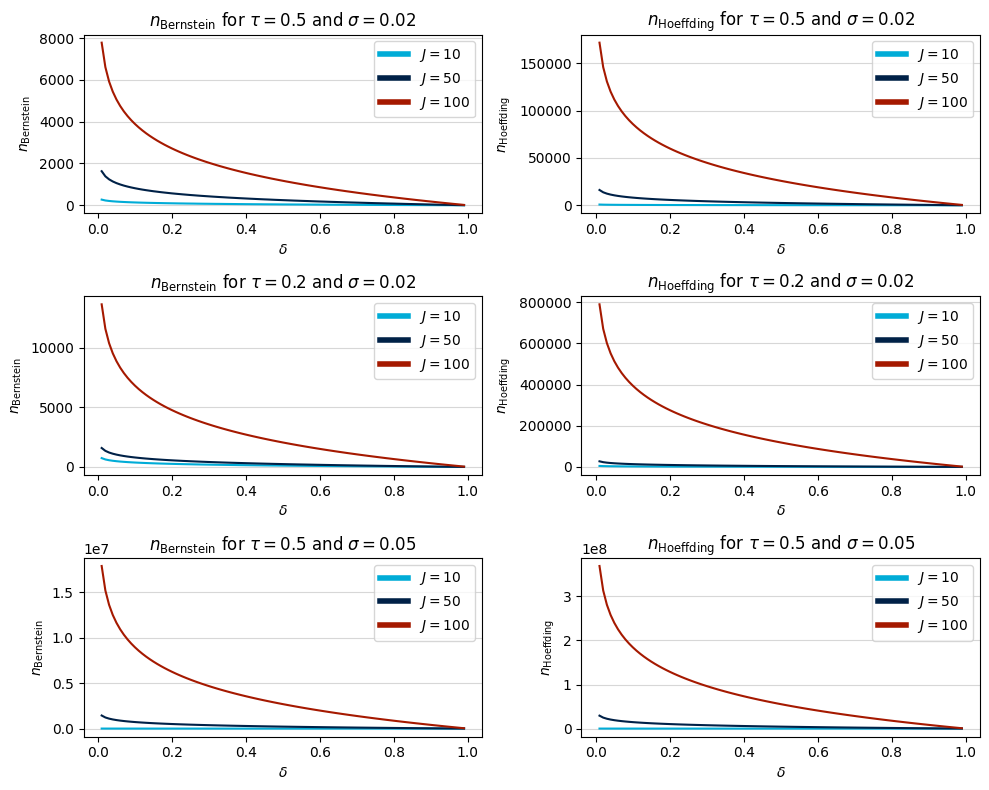

In [72]:
# N
colors = ["#A51900", "#002147","#00ACD7"][::-1]
def n_hoeffding(partition, tau, sigma, delta):
    J = len(partition) - 1
    mu_opt, bounds = get_optimal_mu(partition, tau, sigma, unif_range=True)
    j = np.where(partition == bounds[0])[0][0]
    i_1 = j + 1
    i_2 = j - 1
    diff_1 = mu_opt - get_mu(partition[i_1], partition[i_1 + 1], tau, sigma)
    diff_2 = mu_opt - get_mu(partition[i_2], partition[i_2 + 1], tau, sigma)
    n_hoeff = np.zeros(len(delta))
    for k, d in enumerate(delta):
        n_hoeff[k] = int(2 * np.log(1 / d) * max(((1 - ((j + i_1) / 2 - 1) / J)/ diff_1) ** 2, ((1 - ((j + i_2) / 2 - 1) / J)/ diff_2) ** 2)) + 1
    return n_hoeff
def n_bernstein(partition, tau, sigma, delta):
    J = len(partition) - 1
    mu_opt, bounds = get_optimal_mu(partition, tau, sigma, unif_range=True)
    j = np.where(partition == bounds[0])[0][0]
    i_1 = j + 1
    i_2 = j - 1
    diff_1 = mu_opt - get_mu(partition[i_1], partition[i_1 + 1], tau, sigma)
    diff_2 = mu_opt - get_mu(partition[i_2], partition[i_2 + 1], tau, sigma)
    var_j = get_variance(bounds[0], bounds[1], tau, sigma)
    var_i_1 = get_variance(partition[i_1], partition[i_1 + 1], tau, sigma)
    var_i_2 = get_variance(partition[i_2], partition[i_2 + 1], tau, sigma)
    sigma_ij_1 = (np.sqrt(var_i_1) + np.sqrt(var_j)) / 2
    sigma_ij_2 = (np.sqrt(var_i_2) + np.sqrt(var_j)) / 2
    n_bern = np.zeros(len(delta))
    for k, d in enumerate(delta):
        n_bern[k] = int(2 * np.log(1 / d) * max((sigma_ij_1 + np.sqrt(sigma_ij_1 ** 2 + 3 * diff_1 * (1 - ((j + i_1) / 2 - 1) / J)) / diff_1) ** 2, (sigma_ij_2 + np.sqrt(sigma_ij_2 ** 2 + 3 * diff_2 * (1 - ((j + i_2) / 2 - 1) / J)) / diff_2) ** 2)) + 1
    return n_bern
delta = np.arange(0.01, 1, 0.01)
fig, ax = plt.subplots(3, 2, figsize = (10, 8))
tau = 0.5
sigma = 0.02
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[0,0].plot(delta, n_bernstein(partition, tau, sigma, delta), c = colors[c])
    ax[0,0].set_title(r"$n_{\text{Bernstein}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[0,1].plot(delta, n_hoeffding(partition, tau, sigma, delta), c = colors[c])
    ax[0,1].set_title(r"$n_{\text{Hoeffding}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))

tau = 0.2
sigma = 0.02
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[1,0].plot(delta, n_bernstein(partition, tau, sigma, delta), c = colors[c])
    ax[1,0].set_title(r"$n_{\text{Bernstein}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[1,1].plot(delta, n_hoeffding(partition, tau, sigma, delta), c = colors[c])
    ax[1,1].set_title(r"$n_{\text{Hoeffding}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))
tau = 0.5
sigma = 0.05
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[2,0].plot(delta, n_bernstein(partition, tau, sigma, delta), c = colors[c])
    ax[2,0].set_title(r"$n_{\text{Bernstein}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))
for c, J in enumerate([10, 50, 100]):
    partition = np.linspace(0, 1, J + 1)
    ax[2,1].plot(delta, n_hoeffding(partition, tau, sigma, delta), c = colors[c])
    ax[2,1].set_title(r"$n_{\text{Hoeffding}}$ for $\tau =$" +  str(tau) + " and $\sigma = $" + str(sigma))
for a in ax.flatten():
    a.set_xlabel(r"$\delta$")
    a.grid(axis="y", alpha = 0.5)
for a in ax[:, 0]:
    a.set_ylabel(r"$n_{\text{Bernstein}}$")
for a in ax[:, 1]:
    a.set_ylabel(r"$n_{\text{Hoeffding}}$")
custom_lines = [Line2D([0], [0], color = colors[0], lw=4),
                Line2D([0], [0], color = colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
for a in ax.flatten():
    a.legend(custom_lines, ["$J = 10$", "$J = 50$", "$J = 100$"])

plt.tight_layout()
plt.savefig("../figures/n_bernstein_hoeffding.pdf")
plt.show()

In [357]:
get_mu(0.54, 0.55, tau, sigma)

0.4490836651404633

In [40]:
tau = 0.3
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(123)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_bern = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d)[-2]
        prob_delta_bern[i] += (arm_selected == opti_arm)/n_iter

prob_delta_bern

array([1.    , 0.9952, 0.597 , 0.5586])

In [42]:
tau = 0.7
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(123)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_bern_7 = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d)[-2]
        prob_delta_bern_7[i] += (arm_selected == opti_arm)/n_iter

prob_delta_bern_7

array([0.9996, 0.9682, 0.6744, 0.6872])

In [50]:
tau = 0.5
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(123)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_bern_5 = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d)[-2]
        prob_delta_bern_5[i] += (arm_selected == opti_arm)/n_iter

prob_delta_bern_5

array([1.    , 0.9946, 0.7098, 0.7114])

In [43]:
tau = 0.3
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(123)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_hoeff = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d, bernstein = False)[-2]
        prob_delta_hoeff[i] += (arm_selected == opti_arm)/n_iter
prob_delta_hoeff


array([0.996 , 0.9884, 0.8948, 0.5778])

In [47]:
tau = 0.7
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(173)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_hoeff_7 = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d, bernstein = False)[-2]
        prob_delta_hoeff_7[i] += (arm_selected == opti_arm)/n_iter
prob_delta_hoeff_7

array([0.9998, 0.9884, 0.707 , 0.6936])

In [49]:
tau = 0.5
sigma = 0.02
delta = [0.6, 0.8, 0.99, 0.999]
rndm.seed(173)
partition = np.linspace(0, 1, 31)
opti_arm = np.where(partition == get_optimal_mu(partition, tau, sigma, bsup = 1, unif_range = True)[1][0])[0][0]
n_iter = 5000
prob_delta_hoeff_5 = np.zeros(len(delta))
for i, d in enumerate(delta):
    for _ in range(n_iter):
        arm_selected = sequential_halving_algorithm(tau, sigma, partition, delta = d, bernstein = False)[-2]
        prob_delta_hoeff_5[i] += (arm_selected == opti_arm)/n_iter
prob_delta_hoeff_5

array([0.9992, 0.992 , 0.8132, 0.7006])

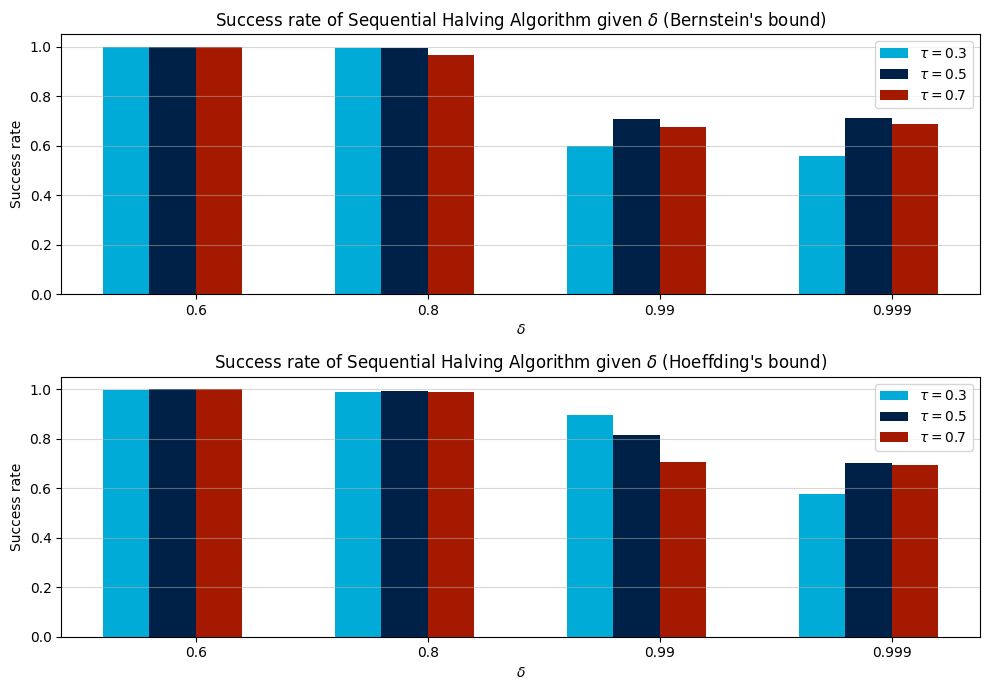

In [69]:
delta = [0.6, 0.8, 0.99, 0.999]
list_sucess_bern = [prob_delta_bern, prob_delta_bern_5, prob_delta_bern_7]
list_sucess_hoeff = [prob_delta_hoeff, prob_delta_hoeff_5, prob_delta_hoeff_7]

delta_axis = np.arange(len(delta)) 
fig, ax = plt.subplots(2, figsize = (10,7))
ax[0].bar(delta_axis - 0.3, prob_delta_bern, 0.2, label = r"$\tau = 0.3$", color = colors[0]) 
ax[0].bar(delta_axis - 0.1, prob_delta_bern_5, 0.2, label = r"$\tau = 0.5$", color = colors[1]) 
ax[0].bar(delta_axis + 0.1, prob_delta_bern_7, 0.2, label = r"$\tau = 0.7$", color = colors[2]) 
ax[0].set_title(f"Success rate of Sequential Halving Algorithm given $\delta$ (Bernstein's bound)")

ax[1].bar(delta_axis - 0.3, prob_delta_hoeff, 0.2, label = r"$\tau = 0.3$", color = colors[0]) 
ax[1].bar(delta_axis - 0.1, prob_delta_hoeff_5, 0.2, label = r"$\tau = 0.5$", color = colors[1]) 
ax[1].bar(delta_axis + 0.1, prob_delta_hoeff_7, 0.2, label = r"$\tau = 0.7$", color = colors[2]) 
ax[1].set_title(f"Success rate of Sequential Halving Algorithm given $\delta$ (Hoeffding's bound)")
for a in ax.flatten():
    a.set_xticks(delta_axis, delta) 
    a.set_xlabel(r"$\delta$") 
    a.set_ylabel("Success rate")
    a.grid(axis = "y", alpha = 0.5) 
    a.legend()
plt.tight_layout()
plt.savefig("../figures/delta_test.pdf")
plt.show() 

In [19]:
def zooming_sha(tau, sigma, partition_size = 4, budget = 5e4, delta = 0.05, seed = None, bernstein = True, oracle = False):
    list_zoom = []
    partition = np.linspace(0, 1, partition_size + 1)
    t = 0
    while t < budget:
        results = sequential_halving_algorithm(tau, sigma, partition, delta, seed, budget - t, bernstein, oracle)
        t += results[-1]
        if t < budget:
            print(t)
            left_index, right_index = results[-3][0], results[-3][2]
            best_range = (partition[results[-2]], partition[results[-2]+1])
            partition = np.linspace(partition[left_index], partition[right_index+1], partition_size + 1)
            list_zoom.append((partition[0], partition[-1]))
    list_zoom.append(best_range)
    return list_zoom



78
3456
3906
10899
18294
Max_iter


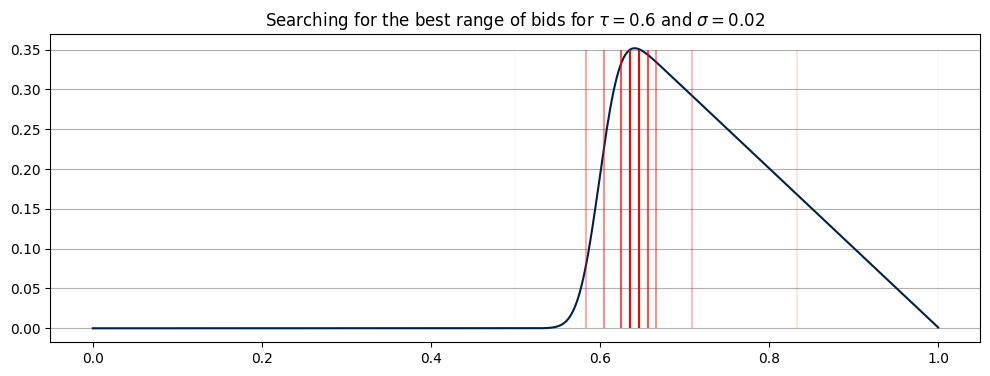

In [30]:
colors = ["#A51900", "#002147","#00ACD7"][::-1]
tau = 0.6
sigma = 0.02
rndm.seed(123)
list_zoom = zooming_sha(tau, sigma, partition_size = 6, bernstein=True, delta = 0.4, budget=5e4)
list_mu = []
partition = np.linspace(0,1,501)
for i in range (len(partition)-1):
    list_mu.append(get_mu(partition[i], partition[i+1], tau, sigma))
plt.plot(partition, [0] + list_mu, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sigma), c = colors[1])
plt.grid(axis = "y")
for i,elm in enumerate(list_zoom):
    plt.vlines(elm[0], ymin= 0, ymax=0.35, colors= "red", alpha = ((i+1)/len(list_zoom))**2)
    plt.vlines(elm[1], ymin= 0, ymax=0.35, colors= "red", alpha = ((i+1)/len(list_zoom))**2)
plt.title(r"Searching for the best range of bids for $\tau=$" + str(tau) + r" and $\sigma=$"+ str(sigma))
plt.savefig("../figures/zooming.pdf")
plt.show()

In [31]:
list_zoom

[(0.5, 1.0),
 (0.5833333333333334, 0.8333333333333333),
 (0.5833333333333334, 0.7083333333333333),
 (0.6041666666666667, 0.6666666666666666),
 (0.625, 0.65625),
 (0.6354166666666667, 0.6458333333333334)]

In [29]:
get_optimal_mu(np.linspace(0,1, 5000),tau, sigma, unif_range= True)

(0.35180959005810974, (0.6399279855971194, 0.6401280256051209))

In [20]:
# Partition of the space
K = 1000 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
# Budget (number of rounds)
T = 500
# Threshold distribution
tau = 0.8
sigma = 0.05
thresholds =  sigma * rndm.randn(T) + tau
mu_star, (a0_star, a1_star) = get_optimal_mu(partition, tau, sigma, unif_range = True)

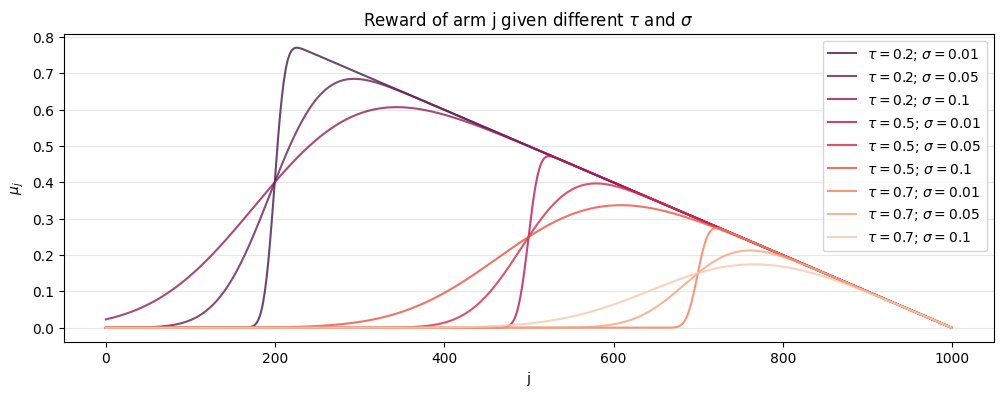

In [21]:
list_mu = []
colors = sns.color_palette("rocket", 10)
c = 0
for tau in [0.2, 0.5, 0.7]:
    for sigma in [0.01, 0.05, 0.1]:
        for i in range (len(partition)-1):
            list_mu.append(get_mu(partition[i], partition[i+1], tau, sigma))
        c += 1
        plt.plot(list_mu, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sigma), c = colors[c], alpha = 0.8)
        list_mu = []
plt.grid(axis= "y", alpha = 0.3)
plt.legend()
plt.xlabel("j")
plt.ylabel(r"$\mu_j$")
plt.title(r"Reward of arm j given different $\tau$ and $\sigma$")
plt.show()

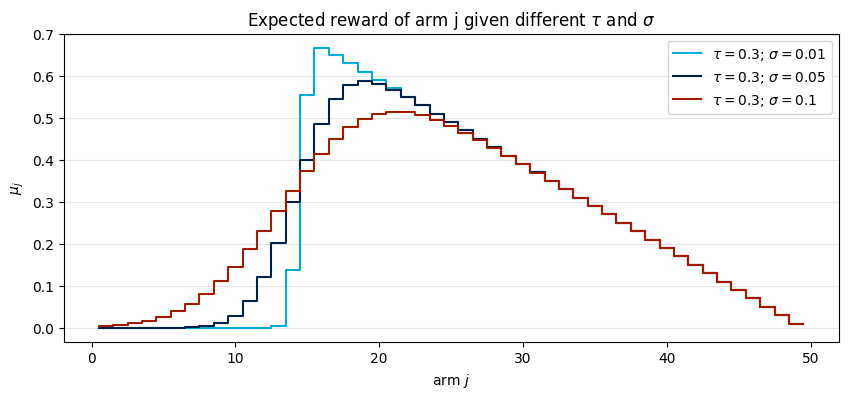

In [109]:
list_mu = []
colors = ["#A51900", "#002147","#00ACD7"][::-1]
c = 0
K = 50 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
plt.rcParams["figure.figsize"] = (10,4)
for tau in [0.3]:
    for sigma in [0.01, 0.05, 0.1]:
        for i in range (len(partition)-1):
            list_mu.append(get_mu(partition[i], partition[i+1], tau, sigma))
        # plt.bar(np.arange(1000)+0.5, list_mu, width = 1, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sigma), color = colors[c], alpha = 0.8)
        plt.step(np.arange(K)+0.5, list_mu, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sigma), color = colors[c])

        c += 1
        list_mu = []
plt.grid(axis= "y", alpha = 0.3)
plt.legend()
plt.xlabel(r"arm $j$")
plt.ylabel(r"$\mu_j$")
plt.title(r"Expected reward of arm j given different $\tau$ and $\sigma$")
plt.savefig("../figures/expect_rew.pdf")
plt.show()

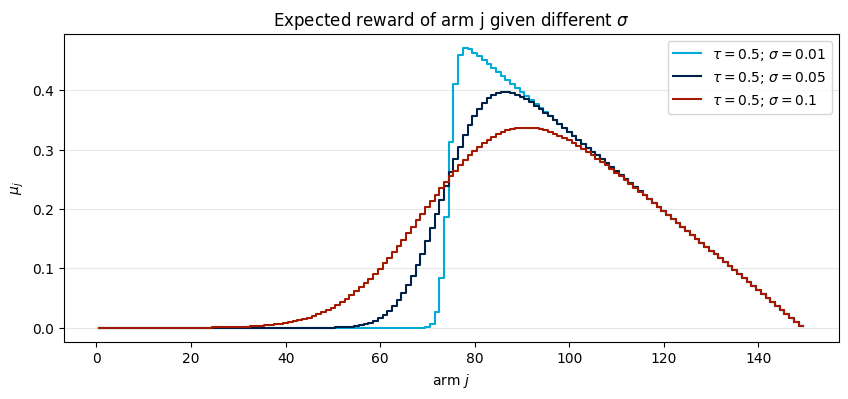

In [107]:
# Steps with a smaller partition
list_mu = []
colors = ["#A51900", "#002147","#00ACD7"][::-1]
c = 0
K = 150
plt.rcParams["figure.figsize"] = (10,4)
partition = np.linspace(0, 1, K+1)
for sigma in [0.01, 0.05, 0.1]:
    for i in range (len(partition)-1):
        list_mu.append(get_mu(partition[i], partition[i+1], 0.5, sigma))
    plt.step(np.arange(K)+0.5, list_mu, label = r"$\tau =$" + str(0.5) + r"; $\sigma=$" + str(sigma), color = colors[c])
    c += 1
    list_mu = []
plt.grid(axis= "y", alpha = 0.3)
plt.legend()
plt.xlabel(r"arm $j$")
plt.ylabel(r"$\mu_j$")
plt.title(r"Expected reward of arm j given different $\sigma$")
plt.savefig("../figures/expect_rew_partition50.pdf")
plt.show()

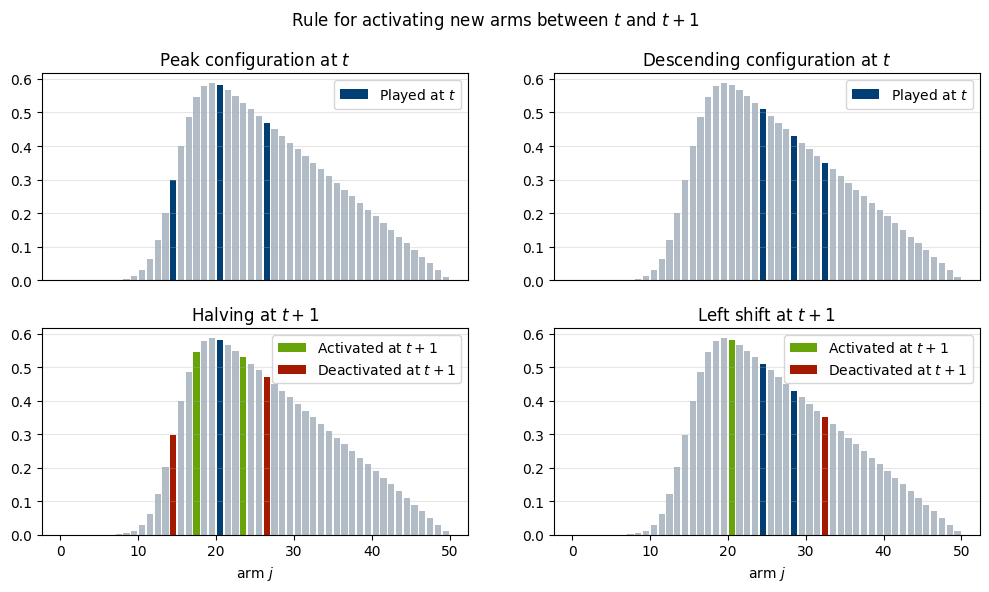

In [82]:
# Steps with a smaller partition
list_mu = []
colors = ["#A51900", "#002147","#00ACD7"][::-1]
c = 0
K = 50
plt.rcParams["figure.figsize"] = (10,6)
partition = np.linspace(0, 1, K+1)
sigma = 0.05
tau = 0.3
fig, axes = plt.subplots(2,2)
for i in range (len(partition)-1):
    list_mu.append(get_mu(partition[i], partition[i+1], tau, sigma))
for ax in axes.flatten(): 
    ax.bar(np.arange(K)+0.5,list_mu, color = colors[1], alpha = 0.3)
    ax.grid(axis= "y", alpha = 0.3)
axes[0,0].bar([14.5, 20.5, 26.5],[list_mu[14], list_mu[20], list_mu[26]], color = blue, label = "Played at $t$")
axes[0,1].bar([24.5, 28.5, 32.5],[list_mu[24], list_mu[28], list_mu[32]], color = blue, label = "Played at $t$")
axes[1,0].bar([17.5, 23.5],[list_mu[17], list_mu[23]], color = green, label = "Activated at $t+1$")
axes[1,1].bar([20.5],[list_mu[20]], color = green, label = "Activated at $t+1$")
axes[1,0].bar([20.5],[list_mu[20]], color = blue)
axes[1,1].bar([24.5, 28.5],[list_mu[24], list_mu[28]], color = blue)
axes[1,0].bar([14.5, 26.5],[list_mu[14], list_mu[26]], color = red, label = "Deactivated at $t+1$")
axes[1,1].bar([32.5],[list_mu[32]], color = red, label = "Deactivated at $t+1$")
axes[0,1].legend()
axes[0,0].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[0,0].set_title("Peak configuration at $t$")
axes[0,1].set_title("Descending configuration at $t$")
axes[1,0].set_title("Halving at $t+1$")
axes[1,1].set_title("Left shift at $t+1$")
axes[0,0].set_xticks([])
axes[0,1].set_xticks([])
axes[1,0].set_xlabel("arm $j$")
axes[1,1].set_xlabel("arm $j$")
fig.suptitle("Rule for activating new arms between $t$ and $t+1$")
plt.tight_layout()
plt.subplots_adjust(wspace = 0.2)
plt.savefig("../figures/sequential_halving.pdf")
plt.show()

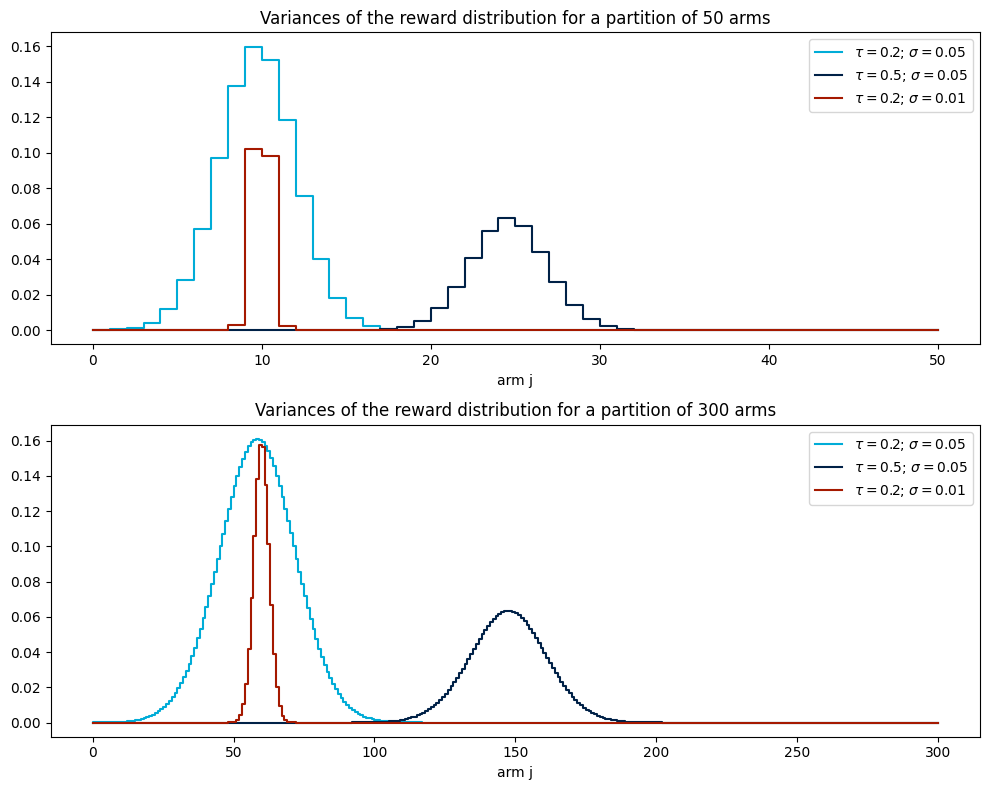

In [26]:
list_v = []
colors = ["#A51900", "#002147","#00ACD7"][::-1]
fig, ax = plt.subplots(2,1, figsize = (10,8))
c = 0
K = 50 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
for tau_sig in [(0.2, 0.05), (0.5, 0.05), (0.2, 0.01)]:
    list_v = [0]
    for j in range(len(partition) - 1):
        tau = tau_sig[0]
        sig = tau_sig[1]
        list_v.append(get_variance(partition[j], partition[j+1], tau, sig))
    ax[0].step(np.arange(K+1), list_v, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sig), color = colors[c])
    c+=1
ax[0].set_xlabel("arm j")
ax[0].legend()
ax[0].set_title("Variances of the reward distribution for a partition of 50 arms")
c = 0
K = 300 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
for tau_sig in [(0.2, 0.05), (0.5, 0.05), (0.2, 0.01)]:
    list_v = [0]
    for j in range(len(partition) - 1):
        tau = tau_sig[0]
        sig = tau_sig[1]
        list_v.append(get_variance(partition[j], partition[j+1], tau, sig))
    ax[1].step(np.arange(K+1), list_v, label = r"$\tau =$" + str(tau) + r"; $\sigma=$" + str(sig), color = colors[c])
    c+=1
ax[1].legend()
ax[1].set_xlabel("arm j")
ax[1].set_title("Variances of the reward distribution for a partition of 300 arms")
plt.tight_layout()
plt.savefig("../figures/variance_rew_partitions.pdf")
plt.show()


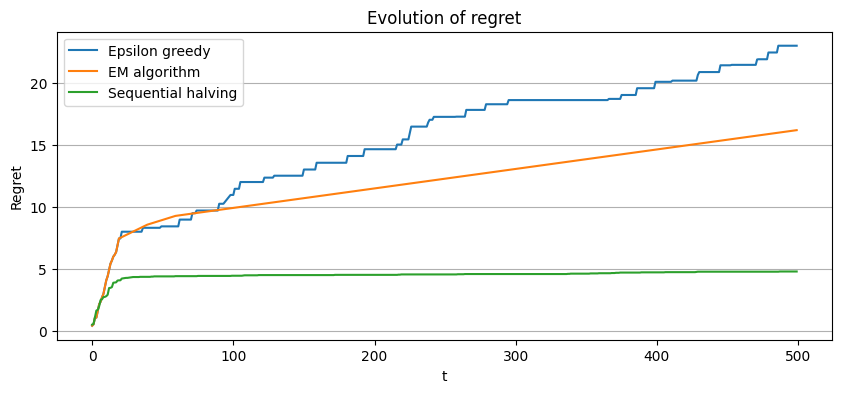

In [25]:
tau = 0.4
sigma = 0.02
thresholds =  sigma * rndm.randn(T) + tau
EM_arms = bandits_EM(thresholds, partition, 20)[0]
eps_greedy_arms = eps_greedy(thresholds, partition, 20, eps = 0.1)[0]
s_h_arms = sequential_halving_algorithm(thresholds, partition, 1)[0]
opt_mu = get_optimal_mu(partition, tau, sigma)
regret_eps_greedy = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in eps_greedy_arms]))
regret_EM = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in EM_arms]))
regret_s_h = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms]))
plt.plot(regret_eps_greedy, label = "Epsilon greedy")
plt.plot(regret_EM, label = "EM algorithm")
plt.plot(regret_s_h, label = "Sequential halving")
plt.legend()
plt.title("Evolution of regret")
plt.ylabel("Regret")
plt.xlabel("t")
plt.grid(axis="y")
plt.show()

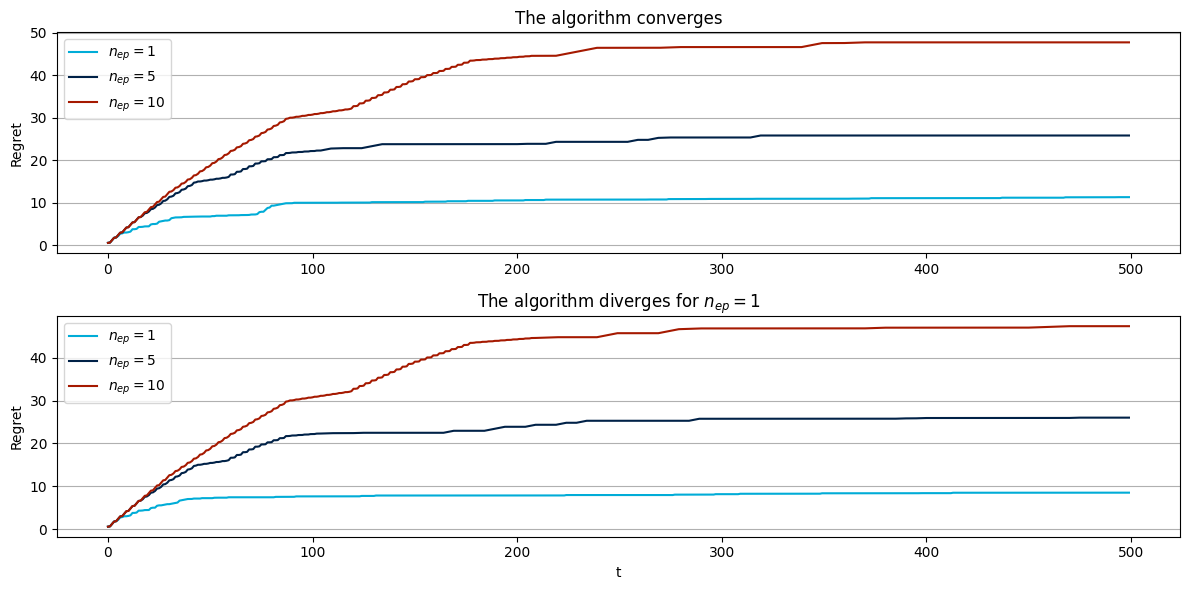

In [26]:
fig, ax = plt.subplots(2,1, figsize = (12,6))
rndm.seed(122)
K = 50 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
tau = 0.4
sigma = 0.01
T = 500
thresholds =  sigma * rndm.randn(T) + tau
s_h_arms1_ = sequential_halving_algorithm(thresholds, partition, 1)[0]
s_h_arms5_ = sequential_halving_algorithm(thresholds, partition, 5)[0]
s_h_arms10_ = sequential_halving_algorithm(thresholds, partition, 10)[0]
opt_mu = get_optimal_mu(partition, tau, sigma)

regret_s_h1 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms1_]))
regret_s_h5 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms5_]))
regret_s_h10 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms10_]))

ax[0].plot(regret_s_h1, c = colors[0], label = "$n_{ep} = 1$")
ax[0].plot(regret_s_h5, c = colors[1], label = "$n_{ep} = 5$")
ax[0].plot(regret_s_h10, c = colors[2], label = "$n_{ep} = 10$")
ax[0].legend()
ax[0].set_title("The algorithm converges")
ax[0].set_ylabel("Regret")
ax[0].grid(axis="y")

rndm.seed(124)
tau = 0.4
sigma = 0.01
T = 500
thresholds =  sigma * rndm.randn(T) + tau
s_h_arms1 = sequential_halving_algorithm(thresholds, partition, 1)[0]
s_h_arms5 = sequential_halving_algorithm(thresholds, partition, 5)[0]
s_h_arms10 = sequential_halving_algorithm(thresholds, partition, 10)[0]
opt_mu = get_optimal_mu(partition, tau, sigma)

regret_s_h1 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms1]))
regret_s_h5 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms5]))
regret_s_h10 = np.cumsum(opt_mu - np.array([get_mu(partition[arm], partition[arm + 1], tau, sigma) for arm in s_h_arms10]))

ax[1].plot(regret_s_h1, c = colors[0], label = "$n_{ep} = 1$")
ax[1].plot(regret_s_h5, c = colors[1], label = "$n_{ep} = 5$")
ax[1].plot(regret_s_h10, c = colors[2], label = "$n_{ep} = 10$")
ax[1].legend()
ax[1].set_title("The algorithm diverges for $n_{ep} = 1$")
ax[1].set_ylabel("Regret")
ax[1].set_xlabel("t")
ax[1].grid(axis="y")
plt.tight_layout()
plt.savefig("../figures/regret.pdf")
plt.show()

In [67]:
print(avg_arm_reward)
print(get_optimal_mu(partition, tau, sigma))
print(partition[mid_index])
print(get_optimal_mu(partition, tau, sigma, unif_range = True)[1][0])

[0.         0.36017053 0.16495348]
0.3734833333332956
0.3333333333333333
0.3333333333333333


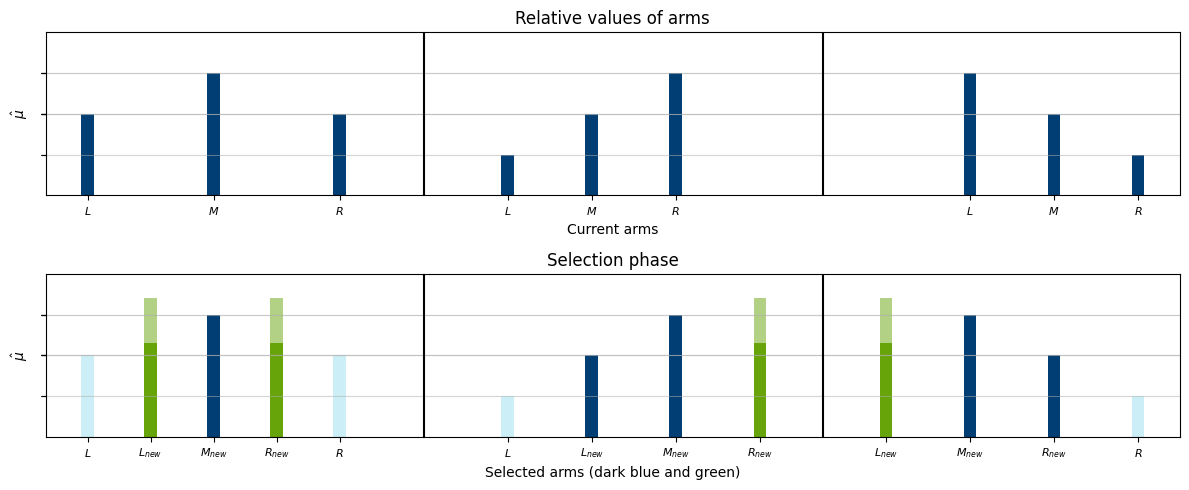

In [46]:
# Sequential halving algorithm illustration:
w_bar = 0.03
plt.rcParams["figure.figsize"] = (12,5)
fig, ax = plt.subplots(2)
sep = 1
bar_x = [0.1, 0.4, 0.7]
bar_x += [sep - 0.1 + 0.2 * x for x in range(1,4)] + [2 * sep + 0.2 * x for x in range(1,4)] 
bar_y = [0.2,0.3,0.4]
bar_y += bar_y[::-1]
bar_y = [0.3,0.4,0.3] + bar_y
ax[0].bar(bar_x, bar_y, width = w_bar, color = blue, alpha = 1)
# ax[0].bar(bar_x[1:], bar_y[1:], width = w_bar, color = colors[0], alpha = 1)
# ax[0].bar(bar_x[0], bar_y[0], width = w_bar, color = colors[0], alpha = 0.2)
# ax[0].bar(bar_x[-1] + 0.2, bar_y[-1]+0.05, width = w_bar, color = green, alpha = 0.5)
# ax[0].bar(bar_x[-1] + 0.2, bar_y[-1]-0.05, width = w_bar, color = green, alpha = 1)
# ax[0].arrow(0.7, 0.25, 0.05, 0, width = 0.01, color = colors[0])
ax[0].vlines((bar_x[3] + bar_x[2]) / 2, 0.1, 0.5, color = "black")
ax[0].vlines((bar_x[6] + bar_x[5]) / 2, 0.1, 0.5, color = "black")
ax[0].set_xticks(bar_x, [r"$L$", r"$M$", r"$R$", r"$L$", r"$M$", r"$R$", r"$L$", r"$M$", r"$R$"], rotation = 0, fontsize = 8)
# r"$L$", r"$L_{new} = M$", r"$M_{new} = R$", r"$R_{new}$"
ax[0].set_yticks(bar_y)
ax[0].set_xlim(0,2.7)
ax[0].set_ylim(0.1,0.5)
ax[0].grid(axis = "y", alpha = 0.3)
ax[0].set_ylabel(r"$\hat{\mu}$")
ax[0].yaxis.set_ticklabels([])
ax[0].set_xlabel("Current arms")
ax[0].set_title("Relative values of arms")

old_arms_x = [bar_x[0], bar_x[2], bar_x[3], bar_x[-1]]
old_arms_y = [bar_y[0], bar_y[2], bar_y[3], bar_y[-1]]
same_arms_x = [bar_x[1], bar_x[4], bar_x[5], bar_x[-3], bar_x[-2]]
same_arms_y = [bar_y[1], bar_y[4], bar_y[5], bar_y[-3], bar_y[-2]]
new_arms_x = [(bar_x[0] + bar_x[1])/2, (bar_x[1] + bar_x[2])/2, 2 * bar_x[5] - bar_x[4], 2 * bar_x[6] - bar_x[7]]
new_arms_y_dark = [bar_y[1] - 0.07] * len(new_arms_x)
new_arms_y_light = [bar_y[1] + 0.04] * len(new_arms_x)
ax[1].bar(same_arms_x, same_arms_y, width = w_bar, color = blue, alpha = 1)
ax[1].bar(old_arms_x, old_arms_y, width = w_bar, color = colors[0], alpha = 0.2)
# ax[2].bar([0.2 + sep, 0.4 + sep], [bar_y_ridge[1]-0.05, bar_y_ridge[1]-0.05], width = 0.03, color = green, alpha = 1)
# ax[2].bar([0.2 + sep, 0.4 + sep], [bar_y_ridge[1]+ 0.05, bar_y_ridge[1]], width = 0.03, color = green, alpha = 0.5)
ax[1].bar(new_arms_x, new_arms_y_light, width = w_bar, color = green, alpha = 0.5)
ax[1].bar(new_arms_x, new_arms_y_dark, width = w_bar, color = green, alpha = 1)

# ax[1].bar(bar_x2[0] - 0.2, bar_y_neg[0] + 0.05, width = w_bar, color = green, alpha = 0.5)
# ax[1].bar(bar_x2[0] - 0.2, bar_y_neg[0]- 0.05, width = w_bar, color = green, alpha = 1)
ax[1].vlines((bar_x[3] + bar_x[2]) / 2, 0.1, 0.5, color = "black")
ax[1].vlines((bar_x[6] + bar_x[5]) / 2, 0.1, 0.5, color = "black")
new_x = old_arms_x + same_arms_x + new_arms_x
new_x.sort()
ax[1].set_xticks(new_x, ["$L$", r"$L_{new}$", r"$M_{new}$", r"$R_{new}$", "$R$", "$L$", r"$L_{new}$", r"$M_{new}$", r"$R_{new}$", r"$L_{new}$", r"$M_{new}$", r"$R_{new}$", "$R$"], fontsize=8)
# r"$L$", r"$L_{new} = M$", r"$M_{new} = R$", r"$R_{new}$"
ax[1].set_yticks(bar_y)
ax[1].set_xlim(0,2.7)
ax[1].set_ylim(0.1,0.5)
ax[1].grid(axis = "y", alpha = 0.3)
ax[1].set_ylabel(r"$\hat{\mu}$")
ax[1].yaxis.set_ticklabels([])
ax[1].set_xlabel("Selected arms (dark blue and green)")
ax[1].set_title("Selection phase")
# ax[1].bar(bar_x, bar_y_neg, width = w_bar, color = colors[0], alpha = 1)
# ax[1].bar(bar_x2[0:-1], bar_y_neg[0:-1], width = w_bar, color = colors[0], alpha = 1)
# ax[1].bar(bar_x2[0] - 0.2, bar_y_neg[0] + 0.05, width = w_bar, color = green, alpha = 0.5)
# ax[1].bar(bar_x2[0] - 0.2, bar_y_neg[0]- 0.05, width = w_bar, color = green, alpha = 1)
# ax[1].bar(bar_x2[-1], bar_y_neg[-1], width = w_bar, color = colors[0], alpha = 0.2)
# ax[1].arrow(0.7, 0.25, 0.05, 0, width = 0.01, color = colors[0])
# ax[1].set_xticks(bar_x + [bar_x2[0] - 0.2] + bar_x2 , [r"$L$", r"$M$", r"$R$", r"$L_{new}$", r"$M_{new} = L$", r"$R_{new} = M$", r"$R$"], rotation = 0)
# ax[1].set_yticks(bar_y)
# ax[1].set_xlim(0,1.8)
# ax[1].set_ylim(0.1,0.5)
# ax[1].grid(axis = "y", alpha = 0.5)
# ax[1].set_ylabel(r"$\hat{\mu}$")
# ax[1].yaxis.set_ticklabels([])


# bar_x = [0.1, 0.3, 0.5]
# bar_x2 = [sep + x for x in bar_x]
# bar_y_ridge = 
# ax[2].bar(bar_x, bar_y_ridge, width = w_bar, color = colors[0], alpha = 1)
# ax[2].bar(bar_x2[1], bar_y_ridge[1], width = w_bar, color = colors[0], alpha = 1)
# ax[2].bar([0.2 + sep, 0.4 + sep], [bar_y_ridge[1]-0.05, bar_y_ridge[1]-0.05], width = 0.03, color = green, alpha = 1)
# ax[2].bar([0.2 + sep, 0.4 + sep], [bar_y_ridge[1]+ 0.05, bar_y_ridge[1]], width = 0.03, color = green, alpha = 0.5)
# ax[2].bar(bar_x2[0], bar_y_neg[-1], width = w_bar, color = colors[0], alpha = 0.2)
# ax[2].bar(bar_x2[-1], bar_y_neg[-1], width = w_bar, color = colors[0], alpha = 0.2)
# ax[2].arrow(0.7, 0.25, 0.05, 0, width = 0.01, color = colors[0])
# ax[2].set_xticks(bar_x + [bar_x2[0], 0.2 + sep, bar_x2[1], 0.4 + sep, bar_x2[2]], [r"$L$", r"$M$", r"$R$", r"$L$",r"$L_{new}$", r"$M_{new} = M$",r"$R_{new}$", r"$R$"], rotation = 40)
# ax[2].set_yticks(bar_y)
# ax[2].set_xlim(0,1.8)
# ax[2].set_ylim(0.1,0.5)
# ax[2].set_xlabel("Selected arms                    ")
# ax[2].grid(axis = "y", alpha = 0.5)
# ax[2].set_ylabel(r"$\hat{\mu}$")
# ax[2].yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("../figures/arm_assignment.pdf")
plt.show()

In [ ]:
def get_fraction_1_tau_known(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return sigma ** 2 * (1 - t_sigma * norm.pdf(t_sigma)/norm.cdf(t_sigma))
def get_fraction_0_tau_known(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return sigma ** 2 * (1 + t_sigma * norm.pdf(t_sigma)/(1 - norm.cdf(t_sigma)))
def EM_known_tau(X_uncensored, bids, deltas, sigma_0,  tau, max_step = 100):
    step = 1
    sigma_n = sigma_0
    results = np.zeros(max_step)
    results[0] = sigma_n
    N = len(X_uncensored)
    M = len(bids)
    if N > 0:
        sum_uncensored = sum((X_uncensored - tau)**2)
    else:
        sum_uncensored = 0
    # print(np.sqrt(sum_uncensored/N))
    while step < max_step:
        sum_censored = 0
        if M > 0:
            for i, bid in enumerate(bids):
                if deltas[i] == 0:
                    sum_censored += get_fraction_0_tau_known(bid, tau, sigma_n)
                else:
                    sum_censored += get_fraction_1_tau_known(bid, tau, sigma_n)
        sigma_n = np.sqrt((sum_uncensored + sum_censored)/ (N + M))
        results[step] = sigma_n
        step += 1
    return results

In [ ]:
def get_fraction_1_unknown(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return - norm.pdf(t_sigma)/norm.cdf(t_sigma)
def get_fraction_0_unknown(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return norm.pdf(t_sigma)/(1 - norm.cdf(t_sigma))
def EM_unknown(X_uncensored, bids, deltas, sigma_0, tau_0, conv = 1e-3, max_step = 100, last_estimate = True):
    step = 1
    tau_n = tau_0
    sigma_n = sigma_0
    taus = [tau_n]
    sigmas = [sigma_n]
    N = len(X_uncensored)
    M = len(bids)
    M_N = M + N
    sum_uncensored = sum(X_uncensored)
    if type(bids) == list:
        bids = np.array(bids)
    while step < max_step:
        if N > 0:
            sample_var = sum((X_uncensored - tau_n)**2)
        else:
            sample_var = 0
        if M > 0:
            fractions = np.zeros(M)
            for i, bid in enumerate(bids):
                if deltas[i] == 0:
                    fractions[i]= get_fraction_0_unknown(bid, tau_n, sigma_n)
                else:
                    fractions[i]= get_fraction_1_unknown(bid, tau_n, sigma_n)
            sum_fractions = sum(fractions)
            bid_tau = bids + tau_n
            sum_bids_taus_fractions = sum(bid_tau * fractions)
        else:
            sum_fractions = 0
            sum_bids_taus_fractions = 0
        tau = 1 / M_N * (sum_uncensored + M * tau_n + sigma_n * sum_fractions)
        sigma_2 = (sample_var + M * (sigma_n ** 2 + (tau - tau_n)**2) + sigma_n * (- 2 * tau * sum_fractions + sum_bids_taus_fractions)) / M_N
        if (abs(tau_n - tau)) <= conv and (abs(sigma_n - np.sqrt(sigma_2)) <= conv):
            break
        tau_n = tau
        sigma_n = np.sqrt(sigma_2)
        taus.append(tau_n)
        sigmas.append(sigma_n)
        step += 1
    if last_estimate:
        return (taus[-1], sigmas[-1])
    else:
        return (taus, sigmas)

In [ ]:
# Bandits using EM algorithm
def bandits_EM(thresholds, partition, nb_rounds, seed = 123, tau_0 = 0.5, sigma_0 = 1):
    rndm.seed(seed)
    l_partition = len(partition)
    avg_arm_reward = np.zeros(l_partition - 1)
    arm_count = np.zeros(l_partition - 1)
    selected_arm = []
    EM_index = 0.5
    episode = 0
    round_ep = 0
    deltas = np.zeros(nb_rounds)
    bids = np.zeros(nb_rounds)
    for tau in thresholds:
        if episode == 0:
            arm_index = rndm.randint(0, l_partition - 1)
        else:
            arm_index = EM_index
        bid = partition[arm_index] + (partition[arm_index + 1] - partition[arm_index]) * rndm.rand()
        bids[round_ep] = bid
        deltas[round_ep] = bid >= tau
        arm_count[arm_index] += 1
        avg_arm_reward[arm_index] = ((arm_count[arm_index] - 1) * avg_arm_reward[arm_index] + reward(bid, tau)) / arm_count[arm_index]
        selected_arm.append(arm_index)
        round_ep += 1
        if round_ep == nb_rounds:
            results = EM_unknown([], bids, deltas, sigma_0, tau_0, conv = 1e-3)
            tau_0 = results[0]
            sigma_0 = results[1]
            a0 = get_optimal_mu(partition, tau_0, sigma_0, unif_range = True)[1][0]
            EM_index = np.where(partition == a0)[0][0]
            episode += 1
            round_ep = 0
            bids = np.zeros(nb_rounds)
            deltas = np.zeros(nb_rounds)
    return selected_arm, avg_arm_reward, arm_count